#### importing the relevant packages and loading the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

from sklearn.preprocessing import StandardScaler

In [2]:
X = pd.read_csv("dengue_features_train.csv")
y = pd.read_csv("dengue_labels_train.csv")
test = pd.read_csv("dengue_features_test.csv")

#### Pre Processing

In [3]:
def mape(Y_test, Y_pred, epsilon = 1):
    return np.mean(np.abs((Y_test - Y_pred + epsilon) / (Y_test + epsilon))) * 100

In [4]:
def extract_month(s):
    return int(s[5:7])

In [5]:
def pre_process(X, train = True):
    # Converting the city column into a boolean, since we just have two cities
    is_sj = X.city == 'sj'

    months = X.week_start_date.apply(extract_month)

    if train:
        # Dropping the rows with null values for now
        X.dropna(inplace=True)
    else:
        X.fillna(0,inplace=True)

    # City based splitting of the data
    X_sj = X[X['city'] == 'sj'].drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1)
    X_iq = X[X['city'] == 'iq'].drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1)
    X_sj_train, X_sj_test = train_test_split(X_sj, shuffle = False)
    X_iq_train, X_iq_test = train_test_split(X_iq, shuffle = False)

    # Concatenating the data again after splitting it
    X_train = pd.concat([X_sj_train, X_iq_train])
    X_test = pd.concat([X_sj_test, X_iq_test])
    X = pd.concat([X_train, X_test])

    # Standardizing the data
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)

    # Adding back the city and month columns after processing
    X['is_sj'] = is_sj.loc[X.index]
    sliced_months = months.loc[X.index]
    month_features = pd.get_dummies(sliced_months)
    X = X.join(month_features)

    return X

In [6]:
X = pre_process(X)

In [7]:
# Selecting y values corresponding to the filtered X values
y = y.total_cases.loc[X.index]

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, shuffle = False)

#### Random Model

In [9]:
y_p = np.full(len(Y_test), np.mean(Y_train))

In [10]:
mean_absolute_error(Y_test, y_p)

17.298857990359657

In [11]:
mape(Y_test, y_p)

265.6300958922601

#### Baseline Model

In [28]:
lr = LinearRegression()

lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
Y_pred = Y_pred.clip(0)

In [29]:
mean_absolute_error(Y_test, Y_pred)

15.468460844046364

In [30]:
mape(Y_test, Y_pred)

175.24782944690435

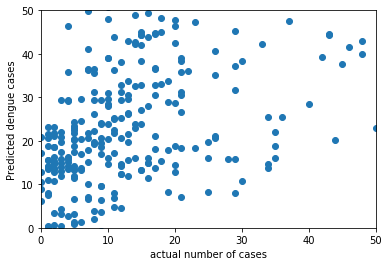

In [17]:
plt.scatter(Y_test, Y_pred)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel("actual number of cases")
plt.ylabel("Predicted dengue cases")
plt.show()

#### Feature Selection using RFE

In [31]:
from sklearn.feature_selection import RFE

# create a base classifier used to evaluate a subset of attributes
model = LinearRegression()

# create the RFE model and select n attributes
rfe = RFE(model, 13)
rfe = rfe.fit(X, y)
X_Select = X.loc[:, rfe.support_]

# Split based on the newly selected features and train and test again
X_train, X_test, Y_train, Y_test = train_test_split(X_Select, y, shuffle = False)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
Y_pred = Y_pred.clip(0)

mean_absolute_error(Y_test, Y_pred)

15.468460844046364

#### L1

In [32]:
clf = linear_model.Lasso(alpha=0.5)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
Y_pred = Y_pred.clip(0)
mean_absolute_error(Y_test, Y_pred)

16.294156546954383

In [24]:
mape(Y_test, Y_pred)

186.97996293084225

#### L2

In [33]:
clf = linear_model.Ridge(alpha = 44)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
Y_pred = Y_pred.clip(0)
mean_absolute_error(Y_test, Y_pred)

15.702107165488444

In [26]:
mape(Y_test, Y_pred)

180.00666020807245

#### Submission

In [53]:
def submission(clf, rfe, filename = 'submission_2.csv'):
    test = pd.read_csv("dengue_features_test.csv")
    submission = test[['city', 'year', 'weekofyear']]
    X_test = pre_process(test, train =False)
    X_test = X_test.loc[:, rfe.support_]
    submission['total_cases'] = clf.predict(X_test).astype(int).clip(0)
    submission.to_csv(filename, index=False)

In [56]:
submission(clf, rfe)

/home/susmeet/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
